# `DuckQ` - Deep Reinforcement Learning for Duck Game

CPSC 480 Final Project. This notebook is not the full project. Please see final report for links to other parts.

Students: Tiger Wang (tiger.wang@yale.edu), Garrek Chan (garrek.chan@yale.edu).

## Overview

This notebook contains the Python game environment declaration (which interfaces with our C# Duck Game server), the training loop, and the evaluation loop. Our game environment setup, which implements a custom `gym.Env`, is implemented from scratch. Our training and evaluation loop is based on the [PyTorch reinforcement learning tutorial](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html#), and we make game-specific modifications.

In [1]:
import gym # We assume gym version >= 0.26
from gym import spaces
from gym.spaces import Box
import numpy as np
from gym.envs.registration import register
import zmq
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
from pathlib import Path
from collections import deque
import random, datetime, os
from gym.wrappers import FrameStack
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

## Game Environment

We implement a custom Gym environment from scratch. `DuckEnv` is inherited from `gym.Env` and implements required signatures such `reset()` and `step()`. The environment logic communicates with the ZeroMQ server that we have implemented in Duck Game for remote control.

In [2]:
class DuckEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, render_mode="human"):
        self.action_space = spaces.Discrete(5)
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(84,84,3),
            dtype=np.uint8
        )

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.zmq_context = zmq.Context()
        #  Socket to talk to server
        self.socket = self.zmq_context.socket(zmq.REQ)
        self.socket.connect("tcp://localhost:5556")

        self.step_count = 0

    def _send(self, bytes):
        self.socket.send(bytes)
    
    def _recv(self):
        return self.socket.recv().decode()

    def _recv_obs(self):
        raw = self._recv()
        kill_str, pixel_str = raw.split(';')
        kill = (kill_str == 'True')
        pixel_1d = np.fromstring(pixel_str, dtype=np.uint8, sep=' ')
        pixel_rgb = np.reshape(pixel_1d, (84,84,3))
        return kill, pixel_rgb

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        self.step_count = 0

        # Start new level
        self._send(b"reset")
        assert self._recv() == "ack"

        # Pass for 150 frames to allow game to initialize
        for _ in range(150):
            self._send(b"pass")
            assert self._recv() == "ack"

        # Do a single step none to populate observation
        self._send(b"step none")
        kill, obs = self._recv_obs()

        return obs, {"kill": kill}

    def step(self, action):        
        if action == 0:
            # Do nothing
            self._send(b"step none")
        elif action == 1:
            # Move left
            self._send(b"step left")
        elif action == 2:
            # Move right
            self._send(b"step right")
        elif action == 3:
            # Grab
            self._send(b"step grab")
        elif action == 4:
            # Shoot
            self._send(b"step shoot")
        else:
            assert False

        kill, obs = self._recv_obs()
        if (obs.shape != (84,84,3)):
            print(obs.shape)
            print(obs)
        reward = 1 if kill else 0

        self.step_count += 1
        if self.step_count > self.spec.max_episode_steps:
            return obs, reward, True, True, {"kill": kill, "TimeLimit.truncated": True}
        else:
            return obs, reward, kill, False, {"kill": kill, "TimeLimit.truncated": False}

In [3]:
register(
    id='DuckGame',
    entry_point='__main__:DuckEnv',
    max_episode_steps=300,
)

### Reused transformations

We use a similar set of wrapper as [[1]](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html#preprocess-environment) except we do not need to resize the observation and we slightly modified `GrayScaleObservation` for bug fixes.

In [4]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        # print(observation.shape)
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        # print(observation.shape)
        return observation[0]

## Neural Network

`DuckQ` is a convolutional neural network that operates on 84x84 4-channel inputs. Each of the 4-channels corresponds to one of the stacked frames. It is based on [[1]]](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html). Duck Game input is also 84x84 grayscale, so we do not need to modify the neural network architecture.

In [5]:
class DuckQNet(nn.Module):
    """mini CNN structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = self.__build_cnn(c, output_dim)

        self.target = self.__build_cnn(c, output_dim)
        self.target.load_state_dict(self.online.state_dict())

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

    def __build_cnn(self, c, output_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

## Logging

We use logging logic based on [[1]](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html). This records each episode's average reward, loss, and length. It also periodically saves average reward line plots to the `checkpoints` directory.

In [6]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt

class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

## Agent Setup

`DuckQ` (`Q` for Q-learning) is the agent that is trying to learn Duck Game. This object contains an instance of `DuckQNet`. It alternates between exploring (taking random actions to gather data) and exploiting (running inference using `DuckQNet`). The exploration rate (epsilon) is initially 100% and decreases by a factor of 0.9999972797. After 10,000 training episodes each with an average of 75 frames, the exploration rate decreases to around 13%. Our implementation is based on [[1]](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html) and [[2]](https://github.com/yfeng997/MadMario/blob/master/agent.py).

In [7]:
class DuckQ:
    def __init__(self, state_dim, action_dim, save_dir, checkpoint=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.device = 'cpu'

        self.net = DuckQNet(self.state_dim, self.action_dim).float()
        self.net = self.net.to(device=self.device)

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.9999972797 # 0.99998994971 # 0.9999975 # 0.99999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        if checkpoint:
            self.load(checkpoint)

        self.save_every = 100000  # no. of experiences between saving Net

    def act(self, state):
        """
        Given a state, choose an epsilon-greedy action and update value of step.
    
        Inputs:
        state(``LazyFrame``): A single observation of the current state, dimension is (state_dim)
        Outputs:
        ``action_idx`` (``int``): An integer representing which action agent will perform
        """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            # print("state1", state.shape, state)
            state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
            # print("state2", state.shape, state)
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            # print("state3", state.shape, state)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

In [8]:
class DuckQ(DuckQ):  # subclassing for continuity
    def __init__(self, state_dim, action_dim, save_dir, checkpoint=None):
        super().__init__(state_dim, action_dim, save_dir, checkpoint)
        self.memory = TensorDictReplayBuffer(storage=LazyMemmapStorage(10000, device=torch.device("cpu"), scratch_dir='tmp'))
        self.batch_size = 32

    def cache(self, state, next_state, action, reward, done):
        """
        Store the experience to self.memory (replay buffer)

        Inputs:
        state (``LazyFrame``),
        next_state (``LazyFrame``),
        action (``int``),
        reward (``float``),
        done(``bool``))
        """
        def first_if_tuple(x):
            return x[0] if isinstance(x, tuple) else x
        state = first_if_tuple(state).__array__()
        next_state = first_if_tuple(next_state).__array__()

        # print("cache", state.shape, state)

        state = torch.tensor(state)
        next_state = torch.tensor(next_state)
        action = torch.tensor([action])
        reward = torch.tensor([reward])
        done = torch.tensor([done])

        # self.memory.append((state, next_state, action, reward, done,))
        self.memory.add(TensorDict({"state": state, "next_state": next_state, "action": action, "reward": reward, "done": done}, batch_size=[]))

    def recall(self):
        """
        Retrieve a batch of experiences from memory
        """
        batch = self.memory.sample(self.batch_size).to(self.device)
        state, next_state, action, reward, done = (batch.get(key) for key in ("state", "next_state", "action", "reward", "done"))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

In [9]:
class DuckQ(DuckQ):
    def __init__(self, state_dim, action_dim, save_dir, checkpoint=None):
        super().__init__(state_dim, action_dim, save_dir, checkpoint)
        self.gamma = 0.9

    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

In [10]:
class DuckQ(DuckQ):
    def __init__(self, state_dim, action_dim, save_dir, checkpoint=None):
        super().__init__(state_dim, action_dim, save_dir, checkpoint)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

In [11]:
class DuckQ(DuckQ):
    def save(self):
        save_path = (
            self.save_dir / f"duckq_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"DuckQNet saved to {save_path} at step {self.curr_step}")
        
    def load(self, load_path):
        if not load_path.exists():
            raise ValueError(f"{load_path} does not exist")

        ckp = torch.load(load_path, map_location='cpu')
        exploration_rate = ckp.get('exploration_rate')
        state_dict = ckp.get('model')

        print(f"Loading model at {load_path} with exploration rate {exploration_rate}")
        self.net.load_state_dict(state_dict)
        self.exploration_rate = exploration_rate

In [12]:
class DuckQ(DuckQ):
    def __init__(self, state_dim, action_dim, save_dir, checkpoint=None):
        super().__init__(state_dim, action_dim, save_dir, checkpoint)
        self.burnin = 1e4  # min. experiences before training
        self.learn_every = 3  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def learn(self):
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)

## Training

### Environment Instantiation

In [13]:
env = gym.make('DuckGame')
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = FrameStack(env, num_stack=4)

In [14]:
env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(4, 84, 84),
 0.0,
 False,
 {'kill': False, 'TimeLimit.truncated': False}


C:\Users\Tiger J. Wang\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Below is a manual "solution" in which the duck takes 10 steps to the left, picks up the weapon, turns right to face the other duck, and shoot the weapon to eliminate the other duck. Ideally, we want our neural network to converge to a solution like this where `DuckQ` kills the other duck within 300 frames.

In [15]:
# == Manual Solution ==
# for _ in range(10):
#     env.step(1)

# for _ in range(1):
#     env.step(3)

# for _ in range(1):
#     env.step(2)

# for _ in range(1):
#     obs, reward, terminated, _, info = env.step(4)

# for _ in range(10):
#     obs, reward, terminated, _, info = env.step(0)

### Training Loop

We run training for 10,000 episodes and periodically save. Our training loop is based on [[1]](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html).

In [ ]:
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

duckq = DuckQ(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 10000
for e in range(episodes):

    state = env.reset()

    # Play the game!
    while True:

        # Run agent on the state
        action = duckq.act(state)

        # Agent performs action
        next_state, reward, done, trunc, info = env.step(action)

        # Remember
        duckq.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = duckq.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done:
            break

    logger.log_episode()

    if (e % 20 == 0) or (e == episodes - 1):
        logger.record(episode=e, epsilon=duckq.exploration_rate, step=duckq.curr_step)

Using CUDA: False

Episode 0 - Step 76 - Epsilon 0.9997932782886737 - Mean Reward 0.0 - Mean Length 76.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 3.234 - Time 2023-12-18T12:56:08
Episode 20 - Step 1509 - Epsilon 0.9959034754591952 - Mean Reward 0.095 - Mean Length 71.857 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 60.21 - Time 2023-12-18T12:57:08
Episode 40 - Step 2963 - Epsilon 0.9919721369306272 - Mean Reward 0.073 - Mean Length 72.268 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 62.477 - Time 2023-12-18T12:58:11
Episode 60 - Step 4483 - Epsilon 0.9878789376475968 - Mean Reward 0.049 - Mean Length 73.492 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 66.832 - Time 2023-12-18T12:59:18
Episode 80 - Step 6003 - Epsilon 0.983802628234499 - Mean Reward 0.037 - Mean Length 74.111 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 72.131 - Time 2023-12-18T13:00:30
Episode 100 - Step 7489 - Epsilon 0.9798337599510891 - Mean Reward 0.04 - Mean Length 74.13 - Mean Loss 0.0 - Mean Q

In [ ]:
duckq.save()

## Evaluation

We evaluate `DuckQ`. First, we load trained weights from a checkpoint file. Then we run the game for 100 episodes and compute the average reward and success rate. Our evaluation loop is based on [[3]](https://github.com/yfeng997/MadMario/blob/master/replay.py) and [[2]](https://github.com/yfeng997/MadMario/blob/master/agent.py.

Loading model at checkpoints\2023-12-18T02-48-37\duckq_net_2.chkpt with exploration rate 0.8179068615153847


C:\Users\Tiger J. Wang\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0 - Step 76 - Epsilon 0.1 - Mean Reward 0.0 - Mean Length 76.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 5.184 - Time 2023-12-18T03:45:31
Episode 20 - Step 1596 - Epsilon 0.1 - Mean Reward 0.0 - Mean Length 76.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 102.572 - Time 2023-12-18T03:47:13
Episode 40 - Step 3116 - Epsilon 0.1 - Mean Reward 0.0 - Mean Length 76.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 104.8 - Time 2023-12-18T03:48:58


KeyboardInterrupt: 

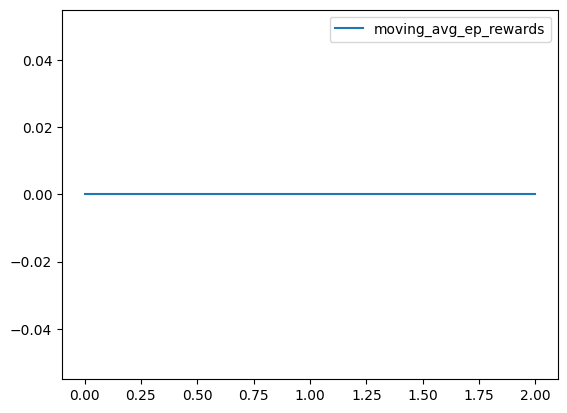

In [13]:
env = gym.make('DuckGame')
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = FrameStack(env, num_stack=4)
env.reset()

save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)
# checkpoints/2023-12-18T02-48-37/duckq_net_2.chkpt - knows how to walk left and pick up gun, but doesn't know how to shoot
checkpoint = Path('checkpoints/2023-12-18T02-48-37/duckq_net_2.chkpt')
duckq = DuckQ(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir, checkpoint=checkpoint)

# Minimize exploration for evaluation 
duckq.exploration_rate = duckq.exploration_rate_min

logger = MetricLogger(save_dir)

episodes = 100
count_success = 0
for e in range(episodes):
    state = env.reset()
    while True:
        action = duckq.act(state)
        next_state, reward, done, trunc, info = env.step(action)
        duckq.cache(state, next_state, action, reward, done)
        logger.log_step(reward, None, None)
        state = next_state
        if info['kill']:
            count_success += 1
            break
        if done:
            break
    logger.log_episode()
    if e % 20 == 0:
        logger.record(
            episode=e,
            epsilon=duckq.exploration_rate,
            step=duckq.curr_step
        )
print("Number of successful kills:", count_success)